In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_source = pd.read_csv('/content/0.csv')
df_source.columns = ['x1','x2','x3','x4','x5','x6']
df_a=df_source.drop(['x1','x2','x3','x4','x6'],axis=1)
df_a

,x4
0,1793
1,1803
2,1811
3,1818
4,1822
...,...
17776,1310
17777,1307
17778,1305
17779,1302


In [ ]:
merged_data = df_a
train = merged_data[0:10000]
test = merged_data[10000:17781]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (10000, 1)
Test dataset shape: (7781, 1)


In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"


In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (10000, 1, 1)
Test data shape: (7781, 1, 1)


In [ ]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu',return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1152      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [ ]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
950/950 [==============================] - 8s 4ms/step - loss: 0.1588 - val_loss: 0.0619
Epoch 2/100
950/950 [==============================] - 4s 4ms/step - loss: 0.0518 - val_loss: 0.0388
Epoch 3/100
950/950 [==============================] - 4s 4ms/step - loss: 0.0282 - val_loss: 0.0135
Epoch 4/100
950/950 [==============================] - 4s 4ms/step - loss: 0.0071 - val_loss: 0.0039
Epoch 5/100
950/950 [==============================] - 4s 4ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 6/100
950/950 [==============================] - 4s 4ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 7/100
950/950 [==============================] - 4s 4ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 8/100
950/950 [==============================] - 4s 4ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 9/100
950/950 [==============================] - 4s 4ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 10/100
950/950 [==============================] - 3s 4ms/step - loss: 0.0026 - val_lo

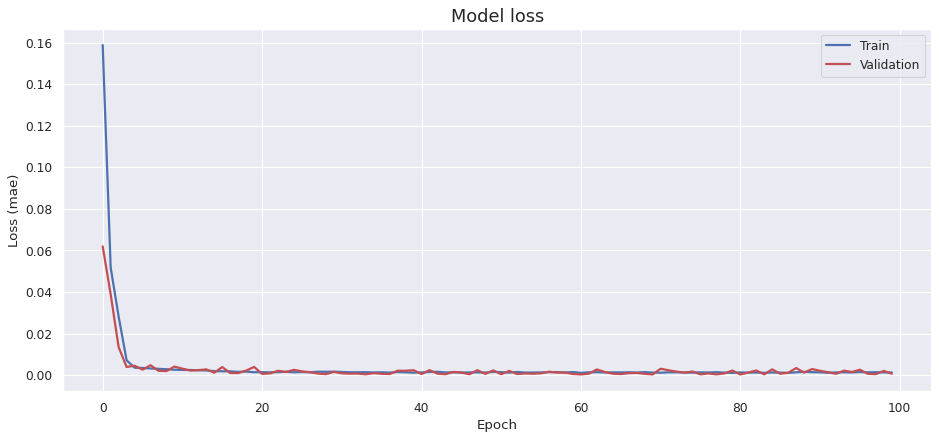

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

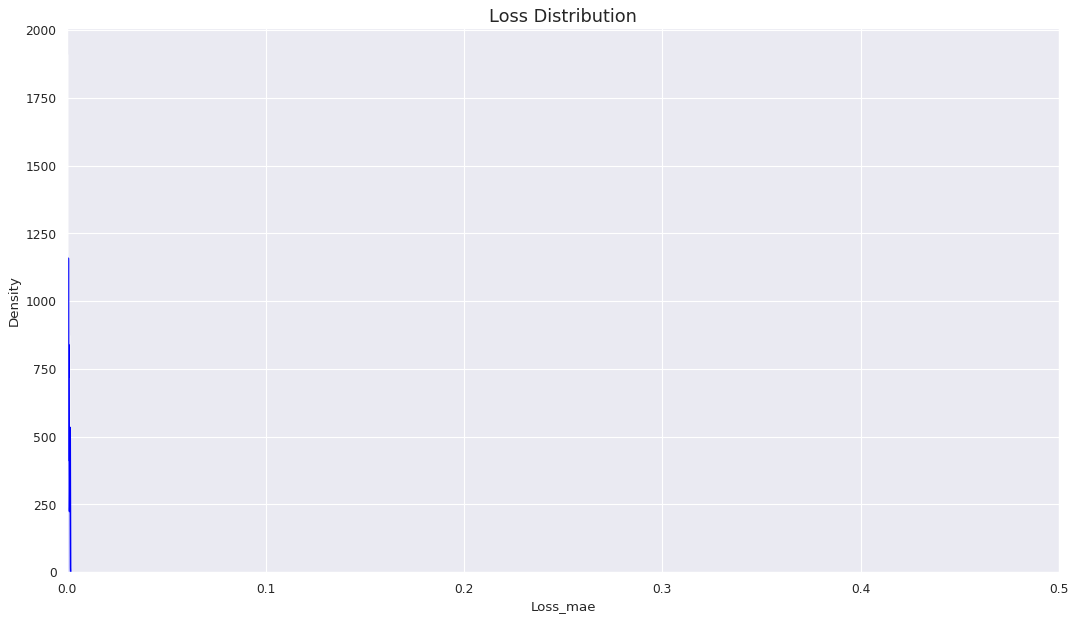

In [ ]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [ ]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

In [ ]:
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

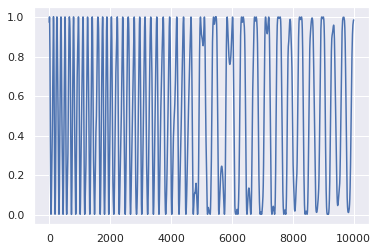

In [ ]:
plt.plot(X_pred_train)

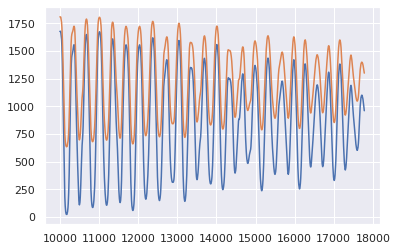

In [ ]:
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
plt.plot(X_pred*1700)
plt.plot(test)